# Chapter 13. Models With Memory

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

from jax import lax
import jax.numpy as np
from jax.random import PRNGKey, randint
from jax.scipy.special import expit

import numpyro as npyro
from numpyro.diagnostics import effective_sample_size
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = (lambda message, category, *args, **kwargs:
                          "{}: {}\n".format(category.__name__, message))
az.style.use("arviz-darkgrid")
npyro.set_host_device_count(4)

### Code 13.1

In [2]:
reedfrogs = pd.read_csv("../data/reedfrogs.csv", sep=";")
d = reedfrogs
d.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


### Code 13.2

In [3]:
# make the tank cluster variable
d["tank"] = np.arange(d.shape[0])

dat = dict(S=d.surv.values, N=d.density.values, tank=d.tank.values)

# approximate posterior
def model(tank, N, S):
    a = npyro.sample("a", dist.Normal(0, 1.5), sample_shape=tank.shape)
    logit_p = a[tank]
    npyro.sample("S", dist.Binomial(N, logits=logit_p), obs=S)

m13_1 = MCMC(NUTS(model), 500, 500, num_chains=4)
m13_1.run(PRNGKey(0), **dat)

### Code 13.3

In [4]:
def model(tank, N, S):
    a_bar = npyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    a = npyro.sample("a", dist.Normal(a_bar, sigma), sample_shape=tank.shape)
    logit_p = a[tank]
    npyro.sample("S", dist.Binomial(N, logits=logit_p), obs=S)

m13_2 = MCMC(NUTS(model), 500, 500, num_chains=4)
m13_2.run(PRNGKey(0), **dat)

### Code 13.4

In [5]:
az.compare({"m13.1": az.from_numpyro(m13_1), "m13.2": az.from_numpyro(m13_2)})

See http://arxiv.org/abs/1507.04544 for details


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m13.2,0,198.771,20.3822,0,0.998423,4.507,0,True,deviance
m13.1,1,214.729,25.6736,15.958,0.00157683,7.06329,3.84244,True,deviance


### Code 13.5

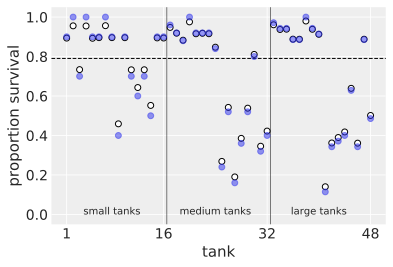

In [6]:
# extract NumPyro samples
post = m13_2.get_samples()

# compute median intercept for each tank
# also transform to probability with logistic
d["propsurv.est"] = expit(np.mean(post["a"], 0))

# display raw proportions surviving in each tank
plt.plot(np.arange(1, 49), d.propsurv, "o", alpha=0.5, zorder=3)
plt.gca().set(ylim=(-0.05, 1.05), xlabel="tank", ylabel="proportion survival")
plt.gca().set(xticks=[1, 16, 32, 48], xticklabels=[1, 16, 32, 48])

# overlay posterior means
plt.plot(np.arange(1, 49), d["propsurv.est"], "ko", mfc="w")

# mark posterior mean probability across tanks
plt.gca().axhline(y=np.mean(expit(post["a_bar"])), c="k", ls="--", lw=1)

# draw vertical dividers between tank densities
plt.gca().axvline(x=16.5, c="k", lw=0.5)
plt.gca().axvline(x=32.5, c="k", lw=0.5)
plt.annotate("small tanks", (8, 0), ha="center")
plt.annotate("medium tanks", (16 + 8, 0), ha="center")
plt.annotate("large tanks", (32 + 8, 0), ha="center");

### Code 13.6

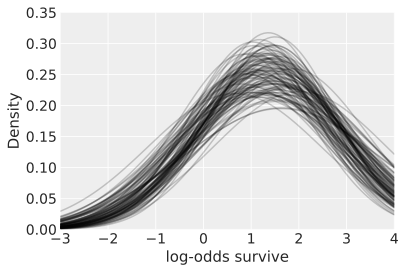

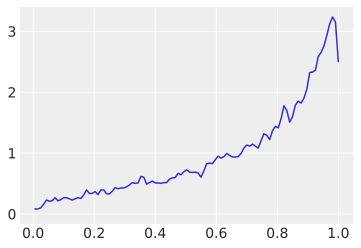

In [7]:
# show first 100 populations in the posterior
plt.subplot(xlim=(-3, 4), ylim=(0, 0.35),
            xlabel="log-odds survive", ylabel="Density")
for i in range(100):
    x = np.linspace(-3, 4, 101)
    plt.plot(x, np.exp(dist.Normal(post["a_bar"][i], post["sigma"][i])
                       .log_prob(x)), "k", alpha=0.2)
plt.show()

# sample 8000 imaginary tanks from the posterior distribution
idxs = randint(PRNGKey(1), (8000,), minval=0, maxval=1999)
sim_tanks = dist.Normal(post["a_bar"][idxs], post["sigma"][idxs]).sample(
    PRNGKey(2))

# transform to probability and visualize
az.plot_kde(expit(sim_tanks), bw=0.3);

### Code 13.7

In [8]:
a_bar = 1.5
sigma = 1.5
nponds = 60
Ni = np.repeat(np.array([5, 10, 25, 35]), repeats=15)

### Code 13.8

In [9]:
a_pond = dist.Normal(a_bar, sigma).sample(PRNGKey(5005), (nponds,))

### Code 13.9

In [10]:
dsim = pd.DataFrame(dict(pond=range(1, nponds + 1), Ni=Ni, true_a=a_pond))

### Code 13.10

In [11]:
print(type(range(3)))
print(type(np.arange(3)))

<class 'range'>
<class 'jax.lax.lax._IotaConstant'>


### Code 13.11

In [12]:
dsim["Si"] = dist.Binomial(dsim.Ni.values, logits=dsim.true_a.values).sample(
    PRNGKey(0))

### Code 13.12

In [13]:
dsim["p_nopool"] = dsim.Si / dsim.Ni

### Code 13.13

In [14]:
dat = dict(Si=dsim.Si.values, Ni=dsim.Ni.values, pond=dsim.pond.values - 1)

def model(pond, Ni, Si):
    a_bar = npyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    a_pond = npyro.sample("a_pond", dist.Normal(a_bar, sigma),
                          sample_shape=pond.shape)
    logit_p = a_pond[pond]
    npyro.sample("Si", dist.Binomial(Ni, logits=logit_p), obs=Si)

m13_3 = MCMC(NUTS(model), 500, 500, num_chains=4)
m13_3.run(PRNGKey(0), **dat)

### Code 13.14

In [15]:
m13_3.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
     a_bar      1.40      0.24      1.39      1.01      1.75   1597.34      1.00
 a_pond[0]      2.69      1.19      2.64      0.84      4.54   2176.65      1.00
 a_pond[1]      1.52      0.99      1.48     -0.07      3.06   2198.78      1.00
 a_pond[2]      2.66      1.17      2.54      0.66      4.32   1624.79      1.00
 a_pond[3]      2.66      1.21      2.52      0.73      4.55   2075.20      1.00
 a_pond[4]      2.68      1.17      2.56      0.95      4.63   2025.20      1.00
 a_pond[5]      2.64      1.15      2.58      0.80      4.38   2350.28      1.00
 a_pond[6]     -0.62      0.87     -0.60     -2.00      0.76   2381.96      1.00
 a_pond[7]      1.57      1.01      1.50     -0.06      3.05   2248.43      1.00
 a_pond[8]      2.70      1.21      2.60      0.60      4.40   1861.96      1.00
 a_pond[9]      0.74      0.85      0.71     -0.52      2.04   2474.19      1.00
a_pond[10]     -1.45      1

### Code 13.15

In [16]:
post = m13_3.get_samples()
dsim["p_partpool"] = np.mean(expit(post["a_pond"]), 0)

### Code 13.16

In [17]:
dsim["p_true"] = expit(dsim.true_a.values)

### Code 13.17

In [18]:
nopool_error = (dsim.p_nopool - dsim.p_true).abs()
partpool_error = (dsim.p_partpool - dsim.p_true).abs()

### Code 13.18

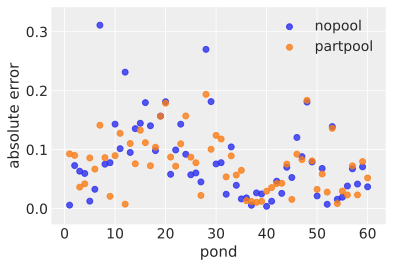

In [19]:
plt.scatter(range(1, 61), nopool_error, label="nopool", alpha=0.8)
plt.gca().set(xlabel="pond", ylabel="absolute error")
plt.scatter(range(1, 61), partpool_error, label="partpool", alpha=0.8)
plt.legend();

### Code 13.19

In [20]:
dsim["nopool_error"] = nopool_error
dsim["partpool_error"] = partpool_error
nopool_avg = dsim.groupby("Ni")["nopool_error"].mean()
partpool_avg = dsim.groupby("Ni")["partpool_error"].mean()

### Code 13.20

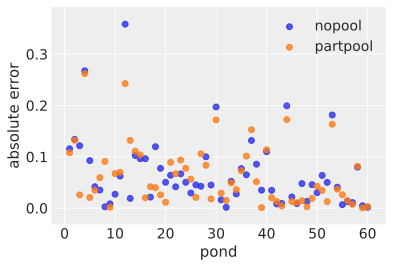

In [21]:
a_bar = 1.5
sigma = 1.5
nponds = 60
Ni = np.repeat(np.array([5, 10, 25, 35]), repeats=15)
a_pond = dist.Normal(a_bar, sigma).sample(PRNGKey(5006), (nponds,))
dsim = pd.DataFrame(dict(pond=range(1, nponds + 1), Ni=Ni, true_a=a_pond))
dsim["Si"] = dist.Binomial(dsim.Ni.values, logits=dsim.true_a.values).sample(
    PRNGKey(0))
dsim["p_nopool"] = dsim.Si / dsim.Ni
newdat = dict(Si=dsim.Si.values, Ni=dsim.Ni.values, pond=dsim.pond.values - 1)
m13_3new = MCMC(NUTS(m13_3.sampler.model), 1000, 1000, num_chains=4)
m13_3new.run(PRNGKey(0), **newdat)

post = m13_3new.get_samples()
dsim["p_partpool"] = np.mean(expit(post["a_pond"]), 0)
dsim["p_true"] = expit(dsim.true_a.values)
nopool_error = (dsim.p_nopool - dsim.p_true).abs()
partpool_error = (dsim.p_partpool - dsim.p_true).abs()
plt.scatter(range(1, 61), nopool_error, label="nopool", alpha=0.8)
plt.gca().set(xlabel="pond", ylabel="absolute error")
plt.scatter(range(1, 61), partpool_error, label="partpool", alpha=0.8)
plt.legend();

### Code 13.21

In [22]:
chimpanzees = pd.read_csv("../data/chimpanzees.csv", sep=";")
d = chimpanzees
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition

dat_list = dict(pulled_left=d.pulled_left.values, actor=d.actor.values - 1,
                block_id=d.block.values - 1, treatment=d.treatment.values - 1)

def model(actor, block_id, treatment, pulled_left=None, link=False):
    # hyper-priors
    a_bar = npyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma_a = npyro.sample("sigma_a", dist.Exponential(1))
    sigma_g = npyro.sample("sigma_g", dist.Exponential(1))
    # adaptive priors
    a = npyro.sample("a", dist.Normal(a_bar, sigma_a), sample_shape=(7,))
    g = npyro.sample("g", dist.Normal(0, sigma_g), sample_shape=(6,))
    b = npyro.sample("b", dist.Normal(0, 0.5), sample_shape=(4,))
    logit_p = a[actor] + g[block_id] + b[treatment]
    if link:
        p = expit(logit_p)
        npyro.sample("p", dist.Delta(p), obs=p)
    npyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m13_4 = MCMC(NUTS(model), 500, 500, num_chains=4)
m13_4.run(PRNGKey(0), **dat_list)
print("Number of divergences:", m13_4.get_extra_fields()["diverging"].sum())

Number of divergences: 19


### Code 13.22


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.36      0.38     -0.36     -0.91      0.36    332.53      1.03
      a[1]      4.74      1.43      4.50      2.70      6.63    546.36      1.00
      a[2]     -0.67      0.37     -0.66     -1.30     -0.10    493.08      1.02
      a[3]     -0.67      0.38     -0.67     -1.32     -0.11    460.02      1.02
      a[4]     -0.36      0.38     -0.35     -0.93      0.31    515.01      1.02
      a[5]      0.56      0.37      0.57     -0.06      1.13    476.81      1.02
      a[6]      2.13      0.46      2.13      1.42      2.89    643.78      1.01
     a_bar      0.59      0.73      0.62     -0.58      1.82    991.68      1.00
      b[0]     -0.13      0.30     -0.13     -0.60      0.35    467.99      1.02
      b[1]      0.40      0.31      0.39     -0.14      0.86    313.06      1.02
      b[2]     -0.47      0.31     -0.47     -0.99      0.00    375.55      1.02
      b[3]      0.29      0

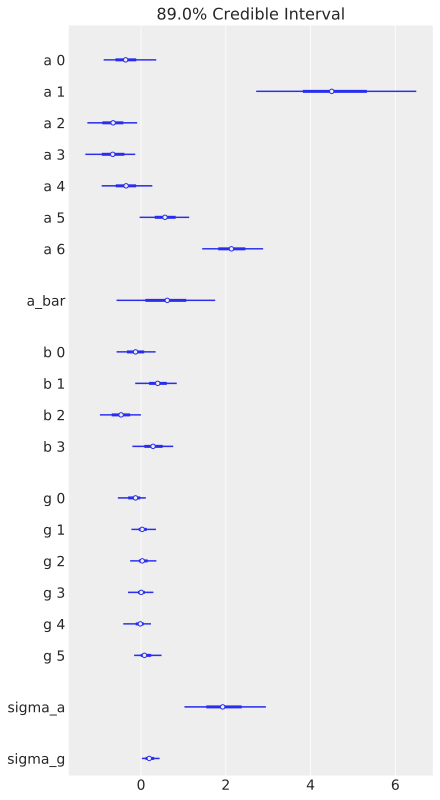

In [23]:
m13_4.print_summary()
post = m13_4.get_samples(group_by_chain=True)
az.plot_forest(post, combined=True, credible_interval=0.89);  # also plot

### Code 13.23

In [24]:
def model(actor, treatment, pulled_left):
    a_bar = npyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma_a = npyro.sample("sigma_a", dist.Exponential(1))
    a = npyro.sample("a", dist.Normal(a_bar, sigma_a), sample_shape=(7,))
    b = npyro.sample("b", dist.Normal(0, 0.5), sample_shape=(4,))
    logit_p = a[actor] + b[treatment]
    npyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m13_5 = MCMC(NUTS(model), 500, 500, num_chains=4)
m13_5.run(PRNGKey(14), dat_list["actor"], dat_list["treatment"],
          dat_list["pulled_left"])

### Code 13.24

In [25]:
az.compare({"m13.4": az.from_numpyro(m13_4), "m13.5": az.from_numpyro(m13_5)})

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m13.5,0,531.519,8.69529,0,0.567695,19.5821,0,False,deviance
m13.4,1,532.239,10.7597,0.720214,0.432305,19.3543,1.83756,False,deviance


### Code 13.25

In [26]:
def model(actor, block_id, treatment, pulled_left):
    a_bar = npyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma_a = npyro.sample("sigma_a", dist.Exponential(1))
    sigma_g = npyro.sample("sigma_g", dist.Exponential(1))
    sigma_b = npyro.sample("sigma_b", dist.Exponential(1))
    a = npyro.sample("a", dist.Normal(a_bar, sigma_a), sample_shape=(7,))
    g = npyro.sample("g", dist.Normal(0, sigma_g), sample_shape=(6,))
    b = npyro.sample("b", dist.Normal(0, sigma_b), sample_shape=(4,))
    logit_p = a[actor] + g[block_id] + b[treatment]
    npyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m13_6 = MCMC(NUTS(model), 500, 500, num_chains=4)
m13_6.run(PRNGKey(16), **dat_list)
print("Number of divergences:", m13_6.get_extra_fields()["diverging"].sum())
{"m13.4": np.mean(m13_4.get_samples()["b"], 0),
 "m13.6": np.mean(m13_6.get_samples()["b"], 0)}

Number of divergences: 34


{'m13.4': DeviceArray([-0.12587382,  0.39807755, -0.47171241,  0.2887916 ],
             dtype=float32),
 'm13.6': DeviceArray([-0.12164628,  0.36740419, -0.43923441,  0.25899717],
             dtype=float32)}

### Code 13.26

In [27]:
np.sum(m13_4.get_extra_fields()["diverging"])

DeviceArray(19, dtype=int32)

### Code 13.27

In [28]:
m13_4b = MCMC(NUTS(m13_4.sampler.model, target_accept_prob=0.99), 500, 500,
              num_chains=4)
m13_4b.run(PRNGKey(13), **dat_list)
np.sum(m13_4b.get_extra_fields()["diverging"])

DeviceArray(4, dtype=int32)

### Code 13.28

In [29]:
def model(actor, block_id, treatment, pulled_left):
    a_bar = npyro.sample("a_bar", dist.Normal(0, 1.5))
    sigma_a = npyro.sample("sigma_a", dist.Exponential(1))
    sigma_g = npyro.sample("sigma_g", dist.Exponential(1))
    z = npyro.sample("z", dist.Normal(0, 1), sample_shape=(7,))
    x = npyro.sample("x", dist.Normal(0, 1), sample_shape=(6,))
    b = npyro.sample("b", dist.Normal(0, 0.5), sample_shape=(4,))
    logit_p = a_bar + z[actor] * sigma_a + x[block_id] * sigma_g + b[treatment]
    npyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)

m13_4nc = MCMC(NUTS(model), 500, 500, num_chains=4)
m13_4nc.run(PRNGKey(16), **dat_list)
print("Number of divergences:", m13_4nc.get_extra_fields()["diverging"].sum())

Number of divergences: 0


### Code 13.29

In [30]:
neff_c = {k: effective_sample_size(v.copy())
          for k, v in m13_4.get_samples(group_by_chain=True).items()}
neff_nc = {k: effective_sample_size(v.copy())
           for k, v in m13_4nc.get_samples(group_by_chain=True).items()}
par_names = []
keys_c = ["b", "a", "g", "a_bar", "sigma_a", "sigma_g"]
keys_nc = ["b", "z", "x", "a_bar", "sigma_a", "sigma_g"]
for k in keys_c:
    if np.ndim(neff_c[k]) == 0:
        par_names += [k]
    else:
        par_names += [k + "[{}]".format(i) for i in range(neff_c[k].size)]
neff_c = np.concatenate([neff_c[k].reshape(-1) for k in keys_c])
neff_nc = np.concatenate([neff_nc[k].reshape(-1) for k in keys_nc])
neff_table = pd.DataFrame(dict(neff_c=neff_c, neff_nc=neff_nc))
neff_table.index = par_names
neff_table.round()

,neff_c,neff_nc
b[0],468.0,1086.0
b[1],313.0,1190.0
b[2],376.0,1240.0
b[3],536.0,1214.0
a[0],333.0,506.0
a[1],546.0,986.0
a[2],493.0,530.0
a[3],460.0,522.0
a[4],515.0,518.0
a[5],477.0,567.0


### Code 13.30

In [31]:
chimp = 2
d_pred = dict(actor=np.repeat(chimp, 4) - 1,
              treatment=np.arange(4),
              block_id=np.repeat(1, 4) - 1)
p = Predictive(m13_4.sampler.model, m13_4.get_samples()).get_samples(
    PRNGKey(0), link=True, **d_pred)["p"]
p_mu = np.mean(p, 0)
p_ci = np.percentile(p, q=(5.5, 94.5), axis=0)

### Code 13.31

In [32]:
post = m13_4.get_samples()
{k: v.reshape(-1)[:5] for k, v in post.items()}

{'a': DeviceArray([ 0.14938772,  6.48652029,  0.06690659, -0.12144832,
              -0.12659532], dtype=float32),
 'a_bar': DeviceArray([-0.0816391 ,  0.98468733,  0.60755652,  0.71678966,
              -0.04959059], dtype=float32),
 'b': DeviceArray([-0.49706304,  0.12828167, -0.72659576,  0.01650289,
              -0.2017149 ], dtype=float32),
 'g': DeviceArray([ 0.0606331 , -0.08904677, -0.16134211, -0.1494175 ,
              -0.21442194], dtype=float32),
 'sigma_a': DeviceArray([3.09017086, 2.89535332, 1.37158239, 1.40661383, 2.17837334],
             dtype=float32),
 'sigma_g': DeviceArray([0.26606306, 0.35196793, 0.21433383, 0.16785987, 0.49408615],
             dtype=float32)}

### Code 13.32

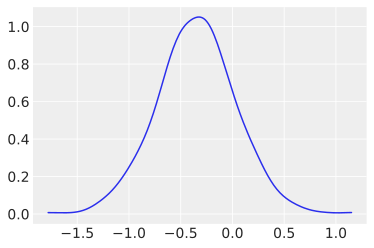

In [33]:
az.plot_kde(post["a"][:, 4]);

### Code 13.33

In [34]:
def p_link(treatment, actor=0, block_id=0):
    a, g, b = post["a"], post["g"], post["b"]
    logodds = a[:, actor] + g[:, block_id] + b[:, treatment]
    return expit(logodds)

### Code 13.34

In [35]:
p_raw = lax.map(lambda i: p_link(i, actor=1, block_id=0), np.arange(4))
p_mu = np.mean(p_raw, 0)
p_ci = np.percentile(p_raw, (5.5, 94.5), 0)

### Code 13.35

In [36]:
def p_link_abar(treatment):
    logodds = post["a_bar"] + post["b"][:, treatment]
    return expit(logodds)

### Code 13.36

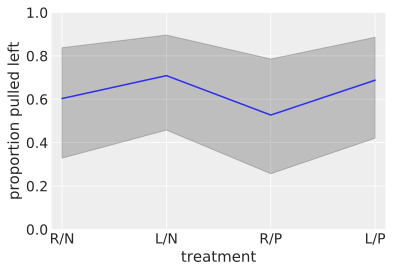

In [37]:
p_raw = lax.map(p_link_abar, np.arange(4))
p_mu = np.mean(p_raw, 1)
p_ci = np.percentile(p_raw, (5.5, 94.5), 1)

plt.subplot(xlabel="treatment", ylabel="proportion pulled left",
            ylim=(0, 1), xlim=(0.9, 4.1))
plt.gca().set(xticks=range(1, 5), xticklabels=["R/N", "L/N", "R/P", "L/P"])
plt.plot(range(1, 5), p_mu)
plt.fill_between(range(1, 5), p_ci[0], p_ci[1], color="k", alpha=0.2);

### Code 13.37

In [38]:
a_sim = dist.Normal(post["a_bar"], post["sigma_a"]).sample(PRNGKey(0))

def p_link_asim(treatment):
    logodds = a_sim + post["b"][:, treatment]
    return expit(logodds)

p_raw_asim = lax.map(p_link_asim, np.arange(4))

### Code 13.38

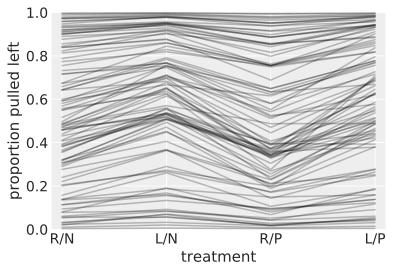

In [39]:
plt.subplot(xlabel="treatment", ylabel="proportion pulled left",
            ylim=(0, 1), xlim=(0.9, 4.1))
plt.gca().set(xticks=range(1, 5), xticklabels=["R/N", "L/N", "R/P", "L/P"])
for i in range(100):
    plt.plot(range(1, 5), p_raw_asim[:, i], color="k", alpha=0.25)

### Code 13.39

In [40]:
bangladesh = pd.read_csv("../data/bangladesh.csv", sep=";")
d = bangladesh
np.sort(d.district.unique())

DeviceArray([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
             16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
             31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
             46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61],
            dtype=int32)

### Code 13.40

In [41]:
d["district_id"] = d.district.astype("category").cat.codes
np.sort(d.district_id.unique())

DeviceArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
             15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
             30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
             45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
            dtype=int32)